In [29]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from Bio import SeqIO
import random
import os 
from tqdm import tqdm
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from time import time
import psutil



In [68]:
def Needleman_alignment(seq1, seq2, match=1, mismatch=-1, gap=-2):
    n, m = len(seq1), len(seq2)
    
    
    values = np.zeros((n + 1, m + 1), dtype=int)
    aligns = np.zeros((n + 1, m + 1), dtype=str)
    
    
    values[:, 0] = np.array([gap*i for i in range(n+1)])
    values[0, :] = np.array([gap*i for i in range(m+1)])
    aligns[1:, 0] = "↑"
    aligns[0, 1:] = "←"
    
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            match_score = values[i - 1, j - 1] + (match if seq1[i - 1] == seq2[j - 1] else mismatch)
            vertucal_score = values[i - 1, j] + gap
            horizontal_score = values[i, j - 1] + gap
            
            values[i, j] = max(match_score, vertucal_score, horizontal_score)
            if values[i, j] == match_score:
                aligns[i, j] = "↖"
            elif values[i, j] == vertucal_score:
                aligns[i, j] = "↑"
            else:
                aligns[i, j] = "←"
    
    
    aligned_seq1, aligned_seq2 = "", ""
    i, j = n, m
    while i > 0 or j > 0:
      
        if aligns[i, j] == "↖":
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1
        elif aligns[i, j] == "↑":
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            i -= 1
        else:  # "←"
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1


    return aligned_seq1, aligned_seq2, values[n, m]

seq1="AGCT"
seq2="ATGCT"

aligned1, aligned2, score = Needleman_alignment(seq1, seq2,mismatch=-1,gap=-2)
print(aligned1)
print(aligned2)
print(score)

A-GCT
ATGCT
2


In [67]:
def Smith_alignment(seq1, seq2, match=1, mismatch=-1, gap=-2):
    n, m = len(seq1), len(seq2)
    
    
    values = np.zeros((n + 1, m + 1), dtype=int)
    
    
    max_score = 0
    max_pos = (0, 0)
    
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            match_score = values[i - 1, j - 1] + (match if seq1[i - 1] == seq2[j - 1] else mismatch)
            vertical_score = values[i - 1, j] + gap
            horizontal_score = values[i, j - 1] + gap
            values[i, j] = max(0, match_score, vertical_score, horizontal_score)  
            
            
            if values[i, j] > max_score:
                max_score = values[i, j]
                max_pos = (i, j)
    
   
    aligned_seq1, aligned_seq2 = "", ""
    i, j = max_pos
    while values[i, j] > 0:
        if values[i, j] == values[i - 1, j - 1] + (match if seq1[i - 1] == seq2[j - 1] else mismatch):
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1
        elif values[i, j] == values[i - 1, j] + gap:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            i -= 1
        else:  # values[i, j] == values[i, j - 1] + gap
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1
    
    return aligned_seq1, aligned_seq2, max_score



seq1 = "AAAAAAAAAAAAAAAAAAAAAAGCTAAAAAAaa"
seq2 = "ATGCT"
aligned1, aligned2, score = Smith_alignment(seq1, seq2)
print(aligned1)
print(aligned2)
print(score)

GCT
GCT
3


In [59]:
class Sequence():
    def __init__(self,id,seq,year,variant) -> None:
        self.id = id
        self.seq = seq 
        self.year = year 
        self.variant = variant
    def __len__(self):
        return len(self.seq)
    
data = []
files = os.listdir("Data")
for file in files :
    name = file.split(".")[0]
    variant,year = name.split("_")[0],name.split("_")[1]
    
    for record in SeqIO.parse(f"Data/{file}","fasta"):
       
        data.append(Sequence(record.id,record.seq,year,variant))

In [60]:
df_data = pd.DataFrame({"id":[d.id for d in data],"seq":[d.seq for d in data],"variant":[d.variant for d in data],"year":[d.year for d in data]})
nucleotide_counts = df_data['seq'].apply(lambda seq: pd.Series({
    'a': seq.count('A')/len(seq),
    'c': seq.count('C')/len(seq),
    'g': seq.count('G')/len(seq),
    't': seq.count('T')/len(seq),
    '-': seq.count('-')/len(seq)
}))

# Concatenate nucleotide counts with the original DataFrame
df_data = pd.concat([df_data, nucleotide_counts], axis=1)
df_data.head()

,id,seq,variant,year,a,c,g,t,-
0,OP723873.1,"(A, G, A, G, T, C, C, A, A, C, C, A, A, C, A, ...",Alpha,2020,0.294469,0.173393,0.179372,0.352765,0.0
1,OL689430.1,"(A, C, C, T, T, C, C, C, A, G, G, T, A, A, C, ...",Alpha,2020,0.298569,0.183652,0.196287,0.321492,0.0
2,OL675863.1,"(G, T, T, T, A, T, A, C, C, T, T, C, C, C, A, ...",Alpha,2020,0.298718,0.183757,0.196311,0.321215,0.0
3,OM443070.1,"(T, G, A, T, T, T, T, A, C, A, G, G, C, T, G, ...",Alpha,2020,0.275240,0.199519,0.193510,0.331731,0.0
4,OM443069.1,"(G, G, C, T, G, C, G, T, T, A, T, A, G, C, T, ...",Alpha,2020,0.273608,0.199758,0.196126,0.330508,0.0


<Axes: >

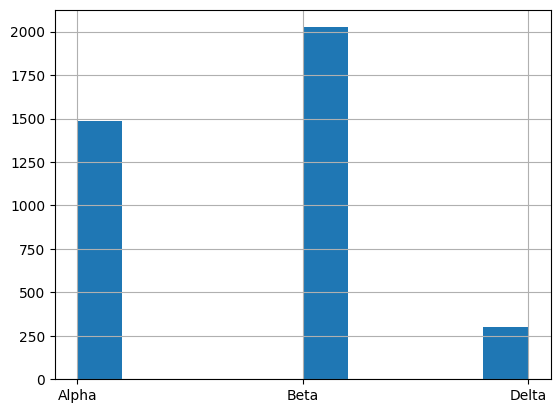

In [64]:
df_data["variant"].hist()


<Axes: >

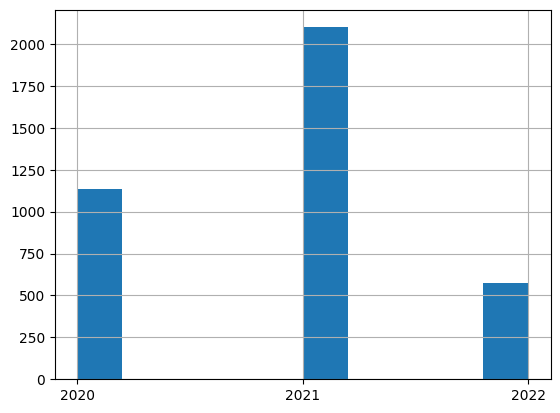

In [63]:
df_data["year"].hist()

In [69]:
seq1,seq2 = data[0],data[3]
aligned1, aligned2, score = Needleman_alignment(seq1.seq, seq2.seq)
print(f"global score :{score}")
seq1,seq2 = data[0],data[3]
aligned1, aligned2, score = Smith_alignment(seq1.seq, seq2.seq)
print(f"local score :{score}")

global score :-167
local score :341


In [34]:
seq_data = [d.seq for d in data if len(d) <= 1000]

In [35]:
alignments = pairwise2.align.localxx(seq_data[0],seq_data[1])
print(len(seq_data))

892


In [36]:
class Genetic():
    def __init__(self,data,num_childrens=10,mutation_rate=0.05,mutation_seq=10,early_stop=2):
        self.data = data
        self.gen_size = num_childrens
        self.mutation_rate = mutation_rate
        self.mutation_seq = mutation_seq
        self.early = early_stop
        self.best_value = None
    
    def cross(self,i,j):
        parents = {"parent1":self.data[i],"parent2":self.data[j]}

        p_size1 = len(parents["parent1"]) 
        p_size2 = len(parents["parent2"])

        p_max = max(p_size1,p_size2)
        align = []
        for c in range(p_max):
            p = np.random.choice([True,False])
            if c < p_size1 and p:
                align.append(parents["parent1"][c])
            elif c < p_size2 and not p :
                align.append(parents["parent2"][c])
            else :
                if c < p_size1 :
                    align.extend(parents["parent1"][c:])
                    break
                else :
                    align.extend(parents["parent2"][c:])
                    break
        return "".join(align)




            
            

        
        
    def mutate(self,protein):
        if np.random.choice([True,False],p=[self.mutation_rate,1-self.mutation_rate]):
            p_size = len(protein)
            start = np.random.randint(0,p_size)
            choices = np.random.choice(['A','G',"T","C","-"],size=self.mutation_seq)
            mutatiion = "".join(choices)

     
            protein = protein[:start]+mutatiion+protein[start+self.mutation_seq:]
        return protein



    
    def find_best(self):
        n = len(self.data)
        pbar = tqdm(total=n*n)
        pbar.set_description("choose Parents")
        best_parents = (0,0)
        best_score = 0
        for i in range(n):
      
            for j in range(n):
                if i!=j:
                    alignments = pairwise2.align.localxx(self.data[i],self.data[j])
            
                    score = alignments[0].score
                    if score > best_score:
                        best_score=score
                        best_parents = (i,j)
                pbar.update(1)
        pbar.close()
        return best_parents,best_score  
      
    def fit(self,iterations):
        scores = []
        best_score = 0
        t0 = time()
        for iter in range(iterations):
            print(f"Gen : {iter}")
            best_parents,score = self.find_best()
            print(score)
            if score > best_score :
                i=0
                best_score=score
            i+=1
            if i == self.early :
                print("early stoppage ...")
                break

            
            scores.append(score)
            new_gen = []
            
            for gen in range(self.gen_size):
                new_gen.append(self.mutate(self.cross(*best_parents)))
            self.data = new_gen
        t_1=time()
        best_parents = self.data[best_parents[0]],self.data[best_parents[1]]
        return scores,best_parents,best_score,t_1-t0

random.shuffle(seq_data)

sample = seq_data[:10]
model = Genetic(sample)



    


In [ ]:
process = psutil.Process(os.getpid())
gen_before_cpu = process.cpu_percent(interval=None)
gen_before_memory = process.memory_info().rss 
history,best_parents,best_score,genetic_time = model.fit(1)
gen_after_cpu = process.cpu_percent(interval=None)
gen_after_memory = process.memory_info().rss   

Gen : 0


choose Parents: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


631.0


In [38]:
print(f"best score :{best_score}")

best score :631.0


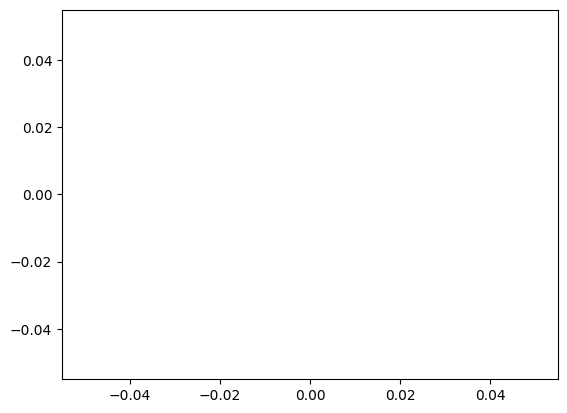

In [39]:
plt.plot(history[1:])

In [40]:

        
def neighbor_joining(distance_matrix, labels):
    while len(labels) > 2:
        n = len(labels)
        
        # Compute the Q-matrix
        q_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    q_matrix[i][j] = (n - 2) * distance_matrix[i][j] - sum(distance_matrix[i]) - sum(distance_matrix[j])
        
        # Find the pair with the minimum Q value
        i, j = np.unravel_index(np.argmin(q_matrix), q_matrix.shape)
        
        # Calculate the distances for the new node
        delta_i = (distance_matrix[i][j] + (sum(distance_matrix[i]) - sum(distance_matrix[j])) / (n - 2)) / 2
        delta_j = distance_matrix[i][j] - delta_i
        
        new_label = f"({labels[i]},{labels[j]})"
        
        # Update the distance matrix
        new_distances = []
        for k in range(n):
            if k != i and k != j:
                new_distance = (distance_matrix[i][k] + distance_matrix[j][k] - distance_matrix[i][j]) / 2
                new_distances.append(new_distance)
        
        # Remove old rows and columns
        distance_matrix = np.delete(distance_matrix, (i, j), axis=0)
        distance_matrix = np.delete(distance_matrix, (i, j), axis=1)
        labels = [label for idx, label in enumerate(labels) if idx != i and idx != j]
        
        # Add the new row and column for the merged node
        distance_matrix = np.vstack([distance_matrix, new_distances])
        new_distances.append(0)
        distance_matrix = np.column_stack([distance_matrix, new_distances])
        labels.append(new_label)
    
    # Final join
    final_label = f"({labels[0]},{labels[1]})"
    return final_label

        
def upgma(distance_matrix, labels):
    while len(labels) > 1:
        n = len(labels)

        # Find the pair with the minimum distance
        i, j = np.unravel_index(np.argmin(distance_matrix + np.eye(n) * np.inf), distance_matrix.shape)

        # Calculate distances for the new node
        new_distances = []
        for k in range(n):
            if k != i and k != j:
                new_distance = (distance_matrix[i][k] + distance_matrix[j][k]) / 2
                new_distances.append(new_distance)

        # Update labels
        new_label = f"({labels[i]},{labels[j]})"

        # Remove old rows and columns
        distance_matrix = np.delete(distance_matrix, (i, j), axis=0)
        distance_matrix = np.delete(distance_matrix, (i, j), axis=1)

        # Add new row and column
        distance_matrix = np.vstack([distance_matrix, new_distances])
        new_distances.append(0)
        distance_matrix = np.column_stack([distance_matrix, new_distances])

        labels = [label for idx, label in enumerate(labels) if idx != i and idx != j]
        labels.append(new_label)

    return labels[0]



In [41]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio import Phylo
import matplotlib.pyplot as plt


def hamming_distance(seq1, seq2):
    
    min_len = min(len(seq1), len(seq2))
    return sum(c1 != c2 for c1, c2 in zip(seq1[:min_len], seq2[:min_len]))

def hamming_distance_matrix(sequences):
   
    n = len(sequences)
    distance_matrix = np.zeros((n, n), dtype=float)

    # Calculate pairwise distances
    for i in range(n):
        for j in range(i, n):
            distance = hamming_distance(sequences[i], sequences[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance  # Symmetric matrix

    return distance_matrix

arr = hamming_distance_matrix(sample)
names = [str(i) for i in range(len(sample))]
matrix  = [[arr[i][j] if j < i else 0 for j in range(i + 1)] for i in range(len(arr))]
print(len(matrix[-1]))
print(len(names))


t_0= time()
process = psutil.Process(os.getpid())
upgma_before_cpu = process.cpu_percent(interval=None)
upgma_before_memory = process.memory_info().rss 

upgma_res = upgma(arr,names)


upgma_after_cpu = process.cpu_percent(interval=None)
upgma_after_memory = process.memory_info().rss  

t_1= time()
nj_before_cpu = process.cpu_percent(interval=None)
nj_before_memory = process.memory_info().rss 

nj_res = neighbor_joining(arr,names)

nj_after_cpu = process.cpu_percent(interval=None)
nj_after_memory = process.memory_info().rss  
t_2= time()

print(nj_res)
# Create a DistanceMatrix
dm = DistanceMatrix(names, matrix)

# Initialize a tree constructor
constructor = DistanceTreeConstructor()
# Neighbor-Joining Tree
nj_tree = constructor.nj(dm)

print("\nNeighbor-Joining Tree:")
Phylo.draw_ascii(nj_tree)
# UPGMA Tree
upgma_tree = constructor.upgma(dm)
print("\nUPGMA Tree:")
Phylo.draw_ascii(upgma_tree)



plt.tight_layout()
plt.show()


10
10
((8,(3,4)),(((5,6),(1,(0,9))),(2,7)))

Neighbor-Joining Tree:
                                                    , 6
       _____________________________________________|
      |                                             | 5
   ___|
  |   |                                                                 , 9
  |   |                                _________________________________|
  |   |_______________________________|                                 | 0
 ,|                                   |
 ||                                   |________________________________ 1
 ||
 ||   ____________________________ 7
 ||__|
_|   |_____________________________________________________________________ 2
 |
 |   ______________________________________________________________ 4
 |__|
 |  |_____________________________________________________________________ 3
 |
 |____________________________________________________________________ 8


UPGMA Tree:
  ____________________________________________

C:\Users\imade\AppData\Local\Temp\ipykernel_25716\1627293600.py:49: RuntimeWarning: invalid value encountered in multiply
  i, j = np.unravel_index(np.argmin(distance_matrix + np.eye(n) * np.inf), distance_matrix.shape)


<Figure size 640x480 with 0 Axes>

In [46]:
ng_time = t_2-t_1
upgma_time = t_1-t_0
upgma_cpu = upgma_after_cpu-upgma_before_cpu
nj_cpu= nj_after_cpu-nj_before_cpu
upgma_ram = upgma_after_memory-upgma_before_memory
nj_ram = nj_after_memory-nj_before_memory
geneic_cpu=gen_after_cpu-gen_before_cpu
genetic_ram=gen_after_memory-gen_before_memory

In [48]:
data = {"algorithm":["upgma","nj","genetic"],"time":[upgma_time,ng_time,genetic_time],"cpu usage":[upgma_cpu,nj_cpu,geneic_cpu],"ram usage(bytes)":[upgma_ram,nj_ram,genetic_ram]}
df = pd.DataFrame(data)
df.head()

,algorithm,time,cpu usage,ram usage(bytes)
0,upgma,0.004000,0.0,0
1,nj,0.006258,104.2,0
2,genetic,31.462288,82.4,21045248


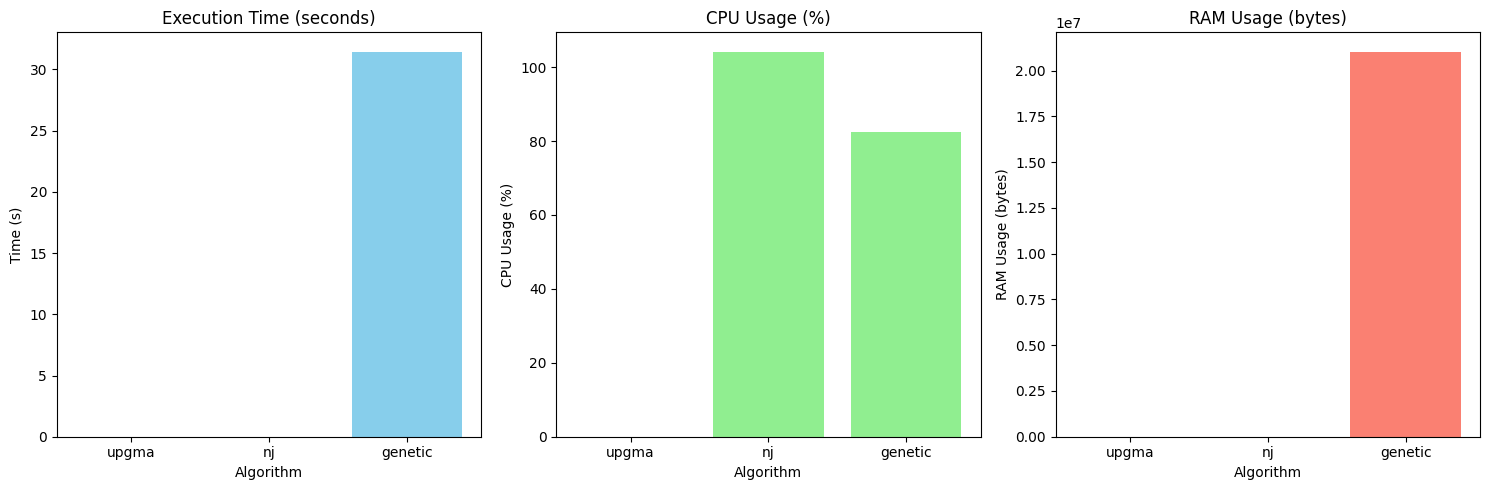

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Time histogram
axes[0].bar(data["algorithm"], data["time"], color='skyblue')
axes[0].set_title('Execution Time (seconds)')
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('Time (s)')

# CPU Usage histogram
axes[1].bar(data["algorithm"], data["cpu usage"], color='lightgreen')
axes[1].set_title('CPU Usage (%)')
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('CPU Usage (%)')

# RAM Usage histogram
axes[2].bar(data["algorithm"], data["ram usage(bytes)"], color='salmon')
axes[2].set_title('RAM Usage (bytes)')
axes[2].set_xlabel('Algorithm')
axes[2].set_ylabel('RAM Usage (bytes)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [44]:
choices = np.random.choice(['A','G',"T","C","-"],size=5)
mutatiion = "".join(choices)
protein = "ABBBBBDCDD"
protein = protein[:1]+mutatiion+protein[1+5:]
protein

'ACAAATDCDD'

In [45]:
import random 
import scipy.stats as st 
import numpy as np

event = ["mutation","no mutation"]

ev = np.random.choice(event,p=[0.1,0.9])

print(ev)

mutation
